[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

We'll log to a project, `langchain-academy`. 

In [ ]:
# _set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
llm.invoke(messages)

AIMessage(content='In addition to whales, there are several other fascinating ocean mammals you can learn about:\n\n1. **Dolphins**: Known for their intelligence and social behavior, dolphins are often found in pods and are known to engage in playful activities.\n\n2. **Porpoises**: Similar to dolphins but generally smaller, porpoises are often more elusive and have a rounder body shape.\n\n3. **Seals**: There are various species of seals, including harbor seals and elephant seals, which can be found in many coastal areas. They are known for their playful nature and adaptability to marine environments.\n\n4. **Sea Lions**: Often mistaken for seals, sea lions are known for their external ear flaps and more social behavior. They can often be seen basking on docks or rocks.\n\n5. **Manatees**: Sometimes referred to as "sea cows," manatees are large, herbivorous mammals that inhabit warm coastal waters and rivers.\n\n6. **Dugongs**: Similar to manatees, dugongs are found mainly in warm coa

We can run our chat model in a simple graph with `MessagesState`.

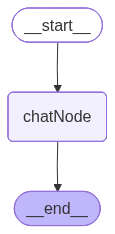

In [6]:
from IPython.display import Markdown, display, Image
from langgraph.graph import StateGraph, START, END, MessagesState

# Node
def chatNode(state: MessagesState):
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

# Graph
bulder = StateGraph(MessagesState)
bulder.add_node("chatNode", chatNode)
bulder.add_edge(START, "chatNode")
bulder.add_edge("chatNode", END)
graph = bulder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several fascinating ocean mammals you might want to explore:

1. **Dolphins**: Known for their intelligence and social behavior, dolphins are part of the cetacean family and come in various species, such as the bottlenose and orca (killer whale).

2. **Porpoises**: Similar to dolphins but generally smaller and with different teeth, porpoises are less social and are found in coastal and freshwater habitats.

3. **Seals**: These marine mammals belong to the pinniped family and include species like harbor seals and elephant seals. They are known for their adaptability to both land an

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

In [12]:
messages[:-1]

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='9cb1ba27-d535-459c-8e14-da4b3d716fea')]

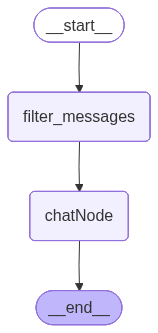

In [15]:
from langchain_core.messages import RemoveMessage

# Node
def filter_messages(state: MessagesState) -> MessagesState:
    delete_messages = [RemoveMessage(m.id) for m in messages[:-2]]
    return {"messages": delete_messages}

# Node
def chatNode(state: MessagesState) -> MessagesState:
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

# Graph
bulder = StateGraph(MessagesState)
bulder.add_node("filter_messages", filter_messages)
bulder.add_node("chatNode", chatNode)
bulder.add_edge(START, "filter_messages")
bulder.add_edge("filter_messages", "chatNode")
bulder.add_edge("chatNode", END)
graph = bulder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are many fascinating ocean mammals to explore beyond whales! Here are some notable ones:

1. **Dolphins** - Known for their intelligence and social behavior, dolphins are often seen in pods and exhibit playful behaviors.

2. **Porpoises** - Similar to dolphins but smaller with different teeth and a more rounded snout, porpoises are also social creatures and are often found in coastal waters.

3. **Seals** - There are several species of seals, including harbor seals and elephant seals. They are often found lounging on rocks or beaches and are known for their swimming abilities.

4. **Sea Lions** - These mari

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

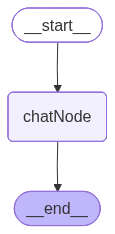

In [17]:
# Node
def chatNode(state: MessagesState) -> MessagesState:
    response = llm.invoke(state["messages"][-1:])
    return {"messages": [response]}

# Graph
bulder = StateGraph(MessagesState)
bulder.add_node("chatNode", chatNode)
bulder.add_edge(START, "chatNode")
bulder.add_edge("chatNode", END)
graph = bulder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [18]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [19]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are many fascinating ocean mammals to explore beyond whales! Here are some notable ones:

1. **Dolphins** - Known for their intelligence and social behavior, dolphins are often seen in pods and exhibit playful behaviors.

2. **Porpoises** - Similar to dolphins but smaller with different teeth and a more rounded snout, porpoises are also social creatures and are often found in coastal waters.

3. **Seals** - There are

In [20]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are many fascinating ocean mammals to explore beyond whales! Here are some notable ones:

1. **Dolphins** - Known for their intelligence and social behavior, dolphins are often seen in pods and exhibit playful behaviors.

2. **Porpoises** - Similar to dolphins but smaller with different teeth and a more rounded snout, porpoises are also social creatures and are often found in coastal waters.

3. **Seals** - There are

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://docs.langchain.com/oss/python/langgraph/add-memory#trim-messages), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

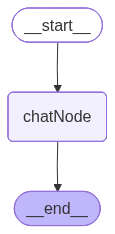

In [21]:
from langchain_core.messages import trim_messages

def chatNode(state: MessagesState) -> MessagesState:
    messages = trim_messages(
        state['messages'],
        max_tokens=100,
        strategy="last",
        token_counter=ChatOpenAI(model="gpt-4o"),
        allow_partial=False,
    )

    return { "messages": [llm.invoke(messages)] }

# Graph
bulder = StateGraph(MessagesState)
bulder.add_node("chatNode", chatNode)
bulder.add_edge(START, "chatNode")
bulder.add_edge("chatNode", END)
graph = bulder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [23]:
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [24]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r